In [1]:
import os
from datetime import datetime
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model
from matplotlib import pyplot as plt

# Assignment 1

In [2]:
A = np.array([[0.5, 1.2],
              [0.3, 0.2]]).T

eigenvalues_A = np.linalg.eigvals(A)
print(f"Eigenvalues for A:{eigenvalues_A}")
print(f"Is every Eigenvalue abs(<1)? {[abs(i) < 1 for i in eigenvalues_A]}")

B1 = np.array([[0.6, 0.4],
               [0.5, 0.2]])
B2 = np.array([[0.1, 0.3],
               [0.2, 0.6]])

additive_matrix = np.block([
    [B1, B2],
    [np.eye(2), np.zeros((2, 2))]
])

eigenvalues_B = np.linalg.eigvals(additive_matrix)
print(f"Eigenvalues for B:{eigenvalues_B}")
print(f"Is every Eigenvalue abs(<1)? {[abs(i) < 1 for i in eigenvalues_B]}")

Eigenvalues for A:[ 0.96846584 -0.26846584]
Is every Eigenvalue abs(<1)? [np.True_, np.True_]
Eigenvalues for B:[ 1.30849576e+00  1.69163780e-01 -3.92066051e-17 -6.77659542e-01]
Is every Eigenvalue abs(<1)? [np.False_, np.True_, np.True_, np.True_]


Since all abs Eigenvalues for A are < 1, stationarity is fulfilled. 

Since one abs Eigenbale for B is > 1, stationarity is not fulfilled.

# Assignment 2

Common range of observation_date: 1959-01-01 00:00:00 to 2025-04-01 00:00:00


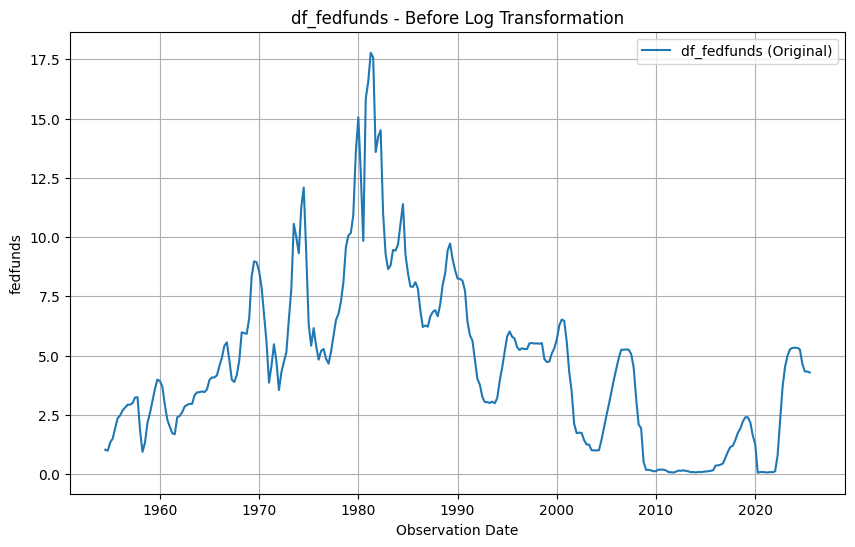

df_fedfunds Index(['observation_date', 'fedfunds'], dtype='object')


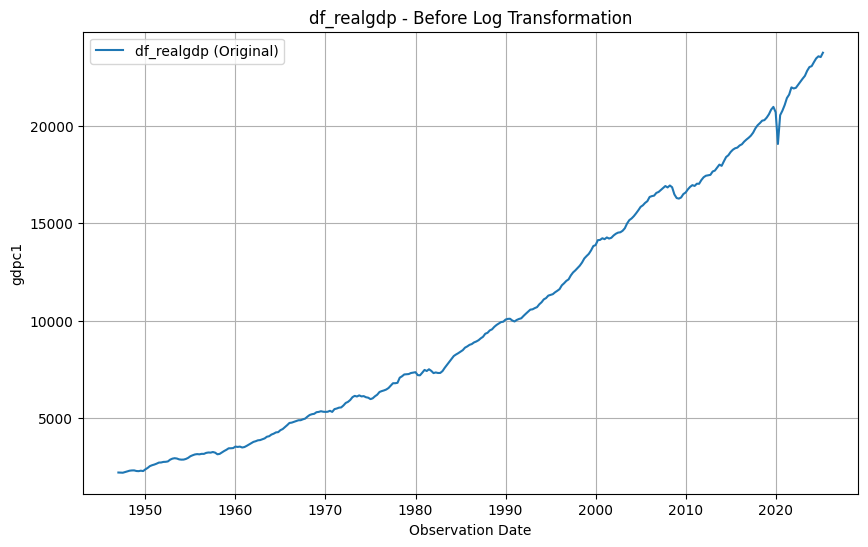

df_realgdp Index(['observation_date', 'gdpc1_log'], dtype='object')


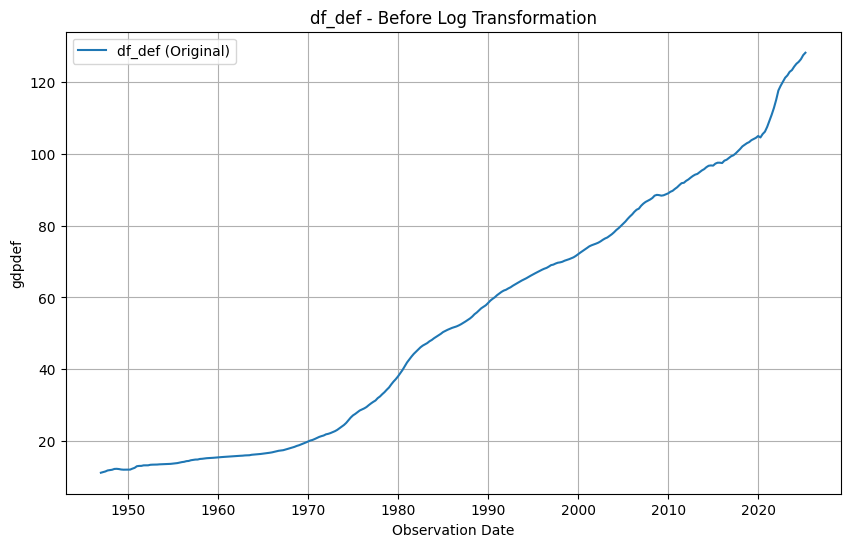

df_def Index(['observation_date', 'gdpdef_log'], dtype='object')


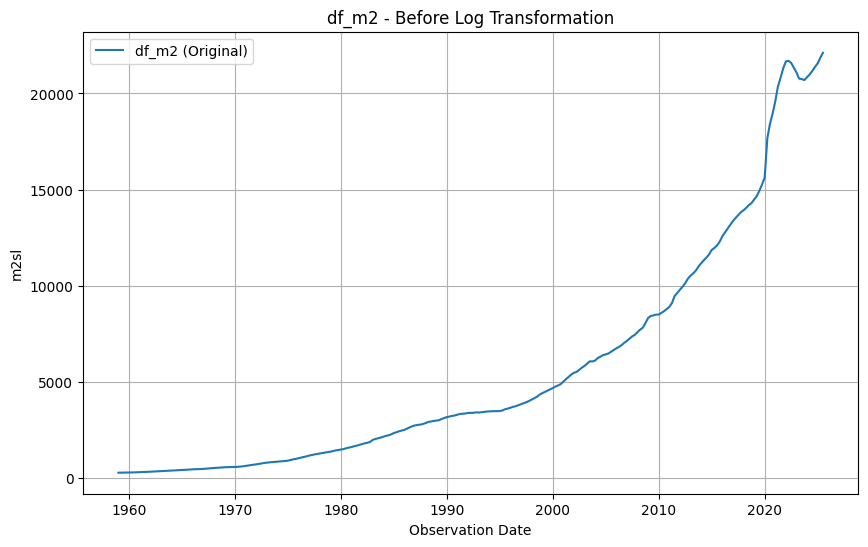

df_m2 Index(['observation_date', 'm2sl_log'], dtype='object')


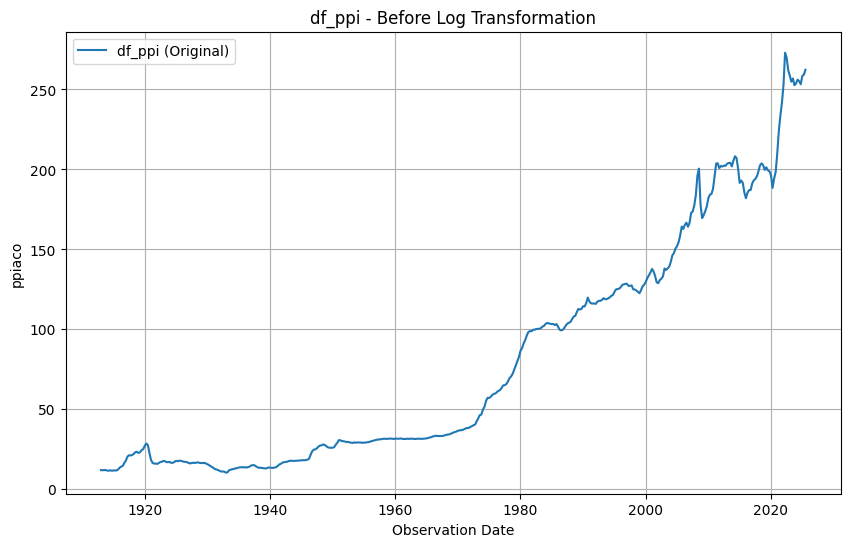

df_ppi Index(['observation_date', 'ppiaco_log'], dtype='object')


In [3]:
file_names = [
    "FEDFUNDS.csv",
    "GDPC1.csv",
    "GDPDEF.csv",
    "M2SL.csv",
    "PPIACO.csv",
]

df_names = [
    "df_fedfunds",
    "df_realgdp",
    "df_def",
    "df_m2",
    "df_ppi",
]

data_folder = "data/task_2/"

dfs = {}

for file_name, df_name in zip(file_names, df_names):
    df = pd.read_csv(f"{data_folder}{file_name}")
    df.columns = df.columns.str.lower()
    df["observation_date"] = pd.to_datetime(df["observation_date"])
    dfs[df_name] = df

common_start = max(df["observation_date"].min() for df in dfs.values())
common_end = min(df["observation_date"].max() for df in dfs.values())
print(f"Common range of observation_date: {common_start} to {common_end}")

for df_name, df in dfs.items():
    plt.figure(figsize=(10, 6))
    plt.plot(df["observation_date"], df.iloc[:, 1], label=f"{df_name} (Original)")
    plt.title(f"{df_name} - Before Log Transformation")
    plt.xlabel("Observation Date")
    plt.ylabel(df.columns[1])
    plt.legend()
    plt.grid()
    plt.show()
    globals()[df_name] = df
    if df_name != 'df_fedfunds':
        df[df.columns[1]] = np.log(df[df.columns[1]])
        df = df.rename(columns={df.columns[1]: f"{df.columns[1]}_log"})
    dfs[df_name] = df
    globals()[df_name] = df 
    
    print(df_name, df.columns)

In [4]:
df_agg = pd.concat([
    df_realgdp.set_index("observation_date")["gdpc1_log"],
    df_def.set_index("observation_date")["gdpdef_log"],
    df_ppi.set_index("observation_date")["ppiaco_log"],
    df_fedfunds.set_index("observation_date")["fedfunds"],
    df_m2.set_index("observation_date")["m2sl_log"],
], axis=1).dropna()

df_agg.columns = ["GDPC1", "GDPDEF", "PPIACO", "FEDFUNDS", "M2SL"]

model = VAR(df_agg)
lag_order = model.select_order(8)
print("Selected lag order based on criteria:")
print(lag_order.summary())

p_aic = lag_order.selected_orders["aic"]
p_bic = lag_order.selected_orders["bic"]

print(f"Optimal lag order (p) based on AIC: {p_aic}")
print(f"Optimal lag order (p) based on BIC: {p_bic}")

Selected lag order based on criteria:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -13.25      -13.18   1.758e-06      -13.22
1      -38.16      -37.75   2.672e-17      -38.00
2      -39.77     -39.01*   5.345e-18      -39.47
3      -39.94      -38.84   4.523e-18     -39.50*
4     -39.94*      -38.50  4.513e-18*      -39.36
5      -39.89      -38.10   4.744e-18      -39.17
6      -39.90      -37.77   4.706e-18      -39.05
7      -39.80      -37.32   5.240e-18      -38.80
8      -39.73      -36.90   5.661e-18      -38.59
-------------------------------------------------
Optimal lag order (p) based on AIC: 4
Optimal lag order (p) based on BIC: 2


Alhough the BIC is more favorable for model parsimony, we will proceed with the AIC-selected lag order for further analysis.

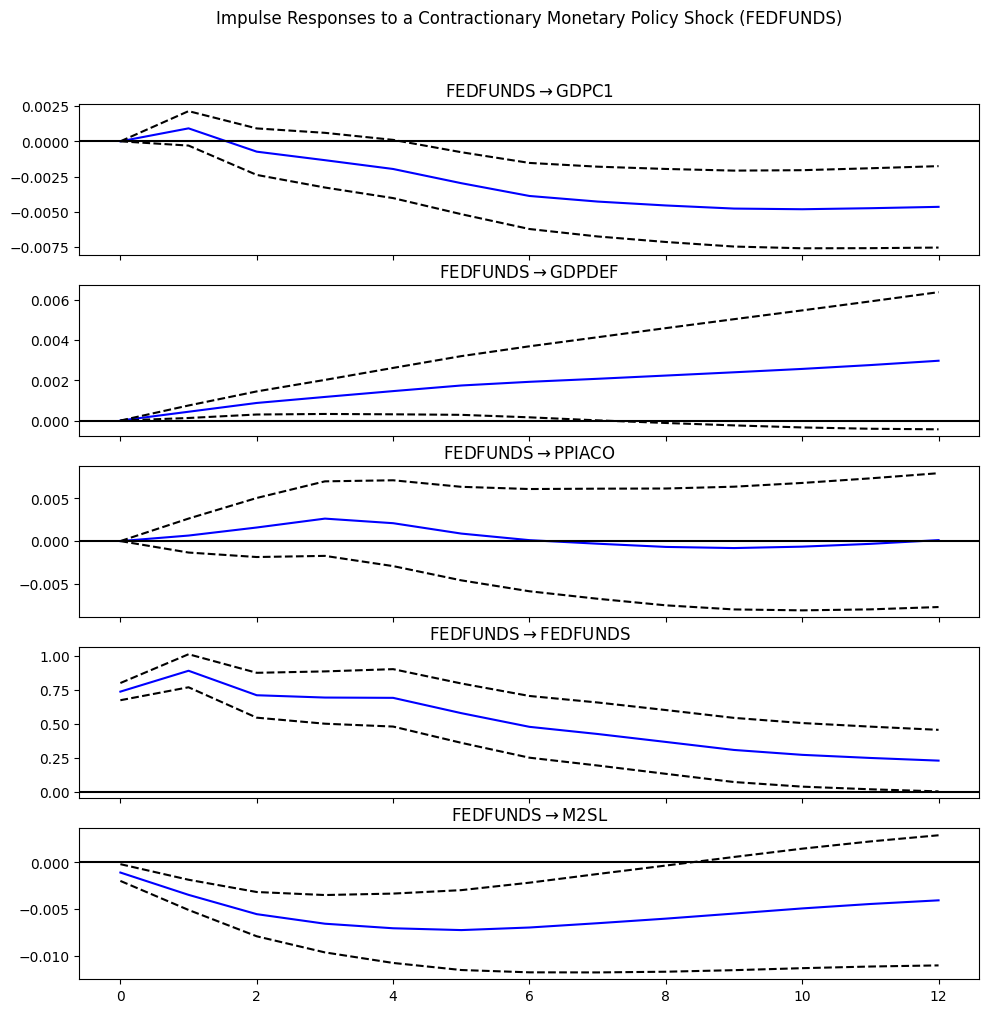

In [5]:
fitted_model = model.fit(p_aic)


irf_12 = fitted_model.irf(12)
irf_12.plot(
    orth=True,
    impulse="FEDFUNDS",
    signif=0.05
)
plt.suptitle(
    "Impulse Responses to a Contractionary Monetary Policy Shock (FEDFUNDS)",
    y=1.02
)
plt.show()


A stringent monetary policy shock raises the federal funds rate persistently and leads to a decline in real activity, prices, and money supply with delays consistent with standard monetary transmission mechanisms. Inflation responds sluggishly, and no price puzzle is observed. The responses decay over time, indicating a stable and stationary VAR.

# Task 3

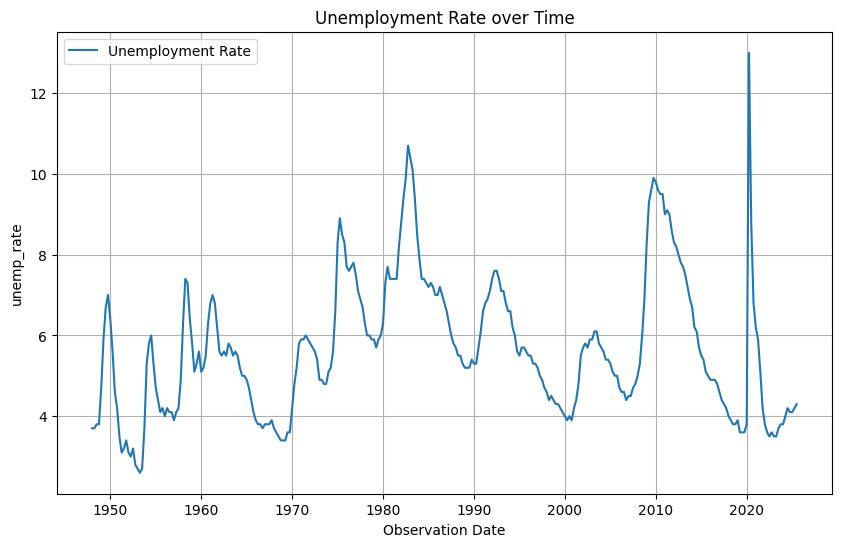

In [6]:
df_unemp = pd.read_csv('data/task_3/UNRATE.csv')
df_unemp.columns = df_unemp.columns.str.lower()
df_unemp["observation_date"] = pd.to_datetime(df_unemp["observation_date"])

plt.figure(figsize=(10, 6))
plt.plot(df_unemp["observation_date"], df_unemp["unrate"], label="Unemployment Rate")
plt.title("Unemployment Rate over Time")
plt.xlabel("Observation Date")
plt.ylabel("unemp_rate")
plt.legend()
plt.grid()
plt.show()

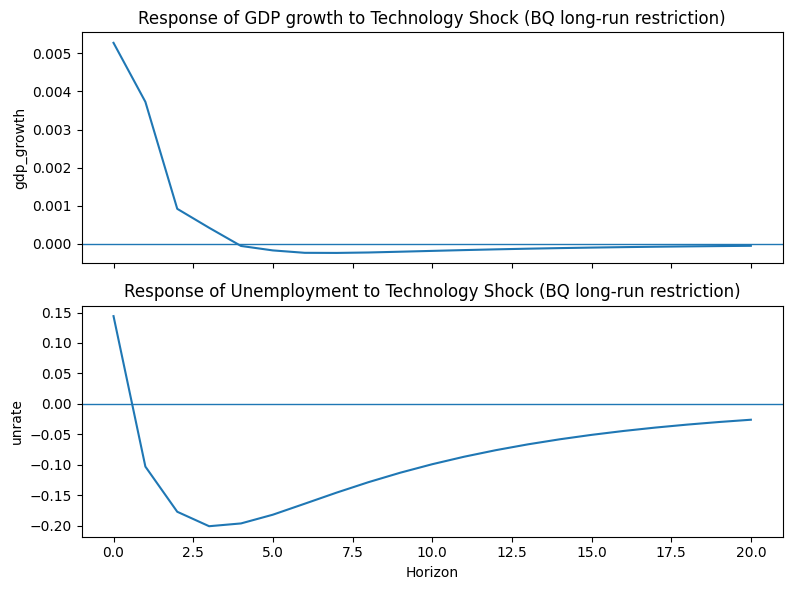

In [7]:
# --- 1) Prepare data (as you already did) ---
df_realgdp["gdp_growth"] = df_realgdp["gdpc1_log"].diff()

df_bivariate = pd.merge(
    df_realgdp[["observation_date", "gdp_growth"]],
    df_unemp[["observation_date", "unrate"]],
    on="observation_date"
).dropna().sort_values("observation_date")

Y = df_bivariate[["gdp_growth", "unrate"]].dropna()

# --- 2) Fit reduced-form VAR ---
var_model = VAR(Y)
var_results = var_model.fit(maxlags=4, ic="aic")

p = var_results.k_ar
k = var_results.neqs  # should be 2

# --- 3) Build long-run matrix F = (I - A1 - ... - Ap)^(-1) ---
A = var_results.coefs  # shape (p, k, k), where A[i] = A_{i+1}
A_sum = A.sum(axis=0)
F = np.linalg.inv(np.eye(k) - A_sum)  # (I - sum A_i)^(-1)

Sigma_e = var_results.sigma_u  # reduced-form residual covariance (k x k)

# --- 4) Impose BQ restriction via Cholesky on long-run covariance ---
# long-run covariance of x is: F Σ_e F'
LR_cov = F @ Sigma_e @ F.T

# Enforce lower-triangular long-run impact matrix C(1)
C1 = np.linalg.cholesky(LR_cov)  # lower triangular

# Recover contemporaneous impact matrix B:
# C(1) = F B  =>  B = F^{-1} C(1) = (I - sum A_i) C(1)
B = (np.eye(k) - A_sum) @ C1

# --- 5) Structural IRFs: Psi_h (reduced-form MA) times B ---
H = 20
Psi = var_results.ma_rep(H)  # array of shape (H+1, k, k), Psi[0]=I

irf_struct = np.array([Psi[h] @ B for h in range(H+1)])  # (H+1, k, k)

# Technology shock is the 1st structural shock (column 0) under BQ ordering:
resp_gdp = irf_struct[:, 0, 0]   # response of gdp_growth
resp_u   = irf_struct[:, 1, 0]   # response of unrate

# --- 6) Plot ---
h = np.arange(H+1)
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ax[0].plot(h, resp_gdp)
ax[0].axhline(0, linewidth=1)
ax[0].set_title("Response of GDP growth to Technology Shock (BQ long-run restriction)")
ax[0].set_ylabel("gdp_growth")

ax[1].plot(h, resp_u)
ax[1].axhline(0, linewidth=1)
ax[1].set_title("Response of Unemployment to Technology Shock (BQ long-run restriction)")
ax[1].set_ylabel("unrate")
ax[1].set_xlabel("Horizon")

plt.tight_layout()
plt.show()

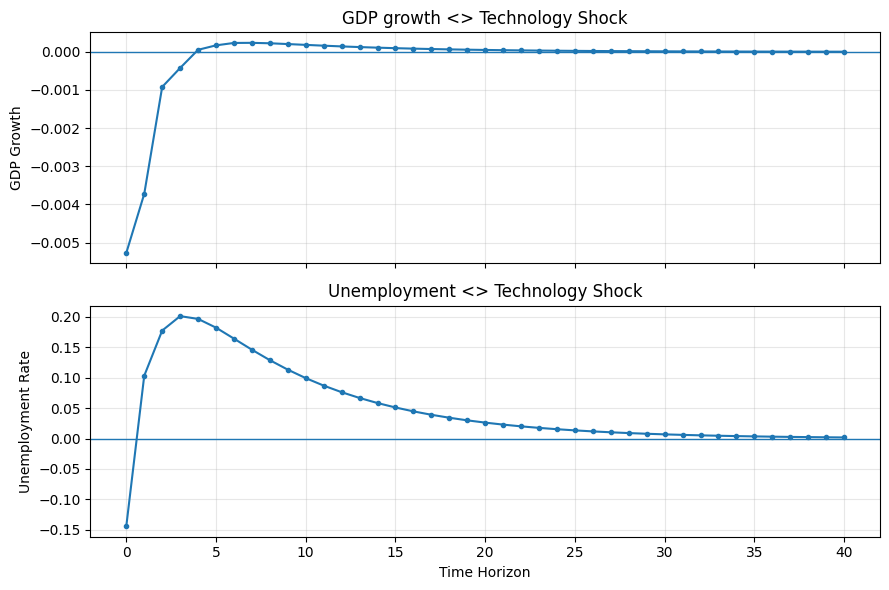

In [8]:
df_realgdp["gdp_growth"] = df_realgdp["gdpc1_log"].diff()

df_merge = pd.merge(
    df_realgdp[["observation_date", "gdp_growth"]],
    df_unemp[["observation_date", "unrate"]],
    on="observation_date"
).dropna().sort_values("observation_date")

Y = df_merge[["gdp_growth", "unrate"]]

res = VAR(Y).fit(maxlags=4, ic="aic")
p = res.k_ar
k = res.neqs

A_sum = res.coefs.sum(axis=0)
F = np.linalg.inv(np.eye(k) - A_sum)

Sigma = res.sigma_u
LR = F @ Sigma @ F.T
C1 = np.linalg.cholesky(LR)

B = (np.eye(k) - A_sum) @ C1

Psi = res.ma_rep(40)
Theta = np.array([Psi[h] @ B for h in range(41)])

if Theta[-1, 0, 0] < 0:
    Theta[:, :, 0] *= -1

resp_gdp = Theta[:, 0, 0]
resp_u   = Theta[:, 1, 0]

h = np.arange(41)

fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

ax[0].plot(h, resp_gdp, marker="o", markersize=3, linewidth=1.5)
ax[0].axhline(0, linewidth=1)
ax[0].set_title("GDP growth <> Technology Shock")
ax[0].set_ylabel("GDP Growth")
ax[0].grid(True, alpha=0.3)

ax[1].plot(h, resp_u, marker="o", markersize=3, linewidth=1.5)
ax[1].axhline(0, linewidth=1)
ax[1].set_title("Unemployment <> Technology Shock")
ax[1].set_ylabel("Unemployment Rate")
ax[1].set_xlabel("Time Horizon")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Task 4

## TGARCH

The TGARCH model is an extension of the standard GARCH model that allows volatility to respond differently to positive and negative shocks. In specific, negative shocks drive volatility more than comparable positive shocks in absolute terms. This asymmetric volatility behavior is commonly observed in financial time series, especially in equity markets.

A typical **TGARCH(1,1)** model is defined as follows:

$$
r_t = \mu + \varepsilon_t, \qquad 
\varepsilon_t = \sqrt{h_t}\, z_t, \qquad 
z_t \sim \text{iid } (0,1)
$$

$$
h_t = \omega 
+ \alpha \varepsilon_{t-1}^2
+ \gamma \varepsilon_{t-1}^2 \mathbf{1}(\varepsilon_{t-1} < 0)
+ \beta h_{t-1}
$$

Here, $\mathbf{1}(\varepsilon_{t-1} < 0)$ is an indicator function that equals one when the lagged innovation is negative and zero otherwise.


**Insights:**

1. **Asymmetry:**  
   $\gamma$ models asymmetry in the response to shocks. If $\gamma$, negative return shocks drive future volatility. This volatility is greater than that generated by positive return shocks of the same magnitude (leverage effect).

2. **Volatility persistence:**  
   The parameter $\beta$  captures persistence in volatility. The parameter $\alpha$  determines the impact of any shock (both positive and negative) on volatility, whereas $\gamma$  represents the asymmetric reaction to negative shocks only.

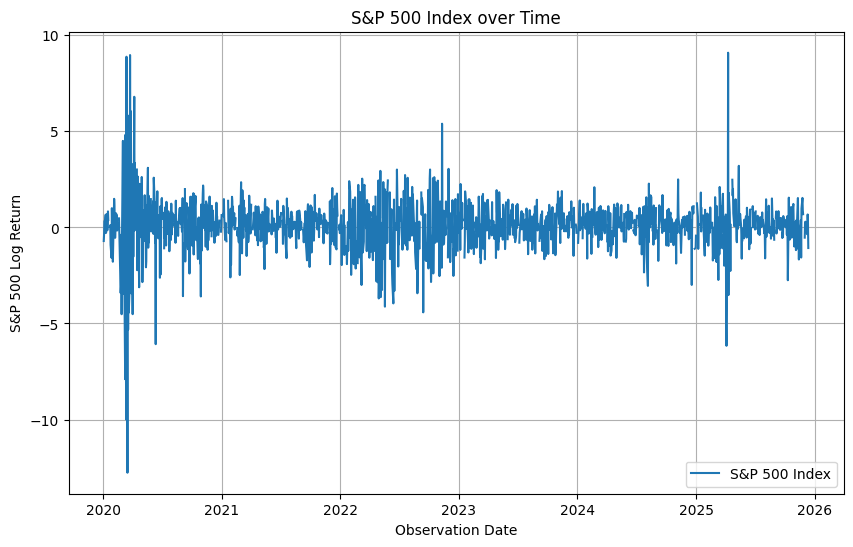

In [9]:
df_sp = pd.read_csv('data/task_4/sp500.csv')
df_sp.columns = df_sp.columns.str.lower()
df_sp["observation_date"] = pd.to_datetime(df_sp["observation_date"])
df_sp["sp500_log_return"] = np.log(df_sp["sp500"] / df_sp["sp500"].shift(1)) * 100
df_sp = df_sp.drop(['sp500'], axis=1)

plt.figure(figsize=(10, 6))
plt.plot(df_sp["observation_date"], df_sp["sp500_log_return"], label="S&P 500 Index")
plt.title("S&P 500 Index over Time")
plt.xlabel("Observation Date")
plt.ylabel("S&P 500 Log Return")
plt.legend()
plt.grid()
plt.show()

In [10]:
print(len(df_sp[df_sp["sp500_log_return"].isna()]))

returns = df_sp["sp500_log_return"].dropna()
print(returns.describe())

tgarch = arch_model(
    returns,
    mean="Constant",
    vol="GARCH",
    p=1,
    o=1,
    q=1,
    dist="normal"
)

tgarch_res = tgarch.fit(disp="off")
print(tgarch_res.summary())


113
count    1439.000000
mean        0.059384
std         1.335324
min       -12.765214
25%        -0.484697
50%         0.111589
75%         0.697874
max         9.089490
Name: sp500_log_return, dtype: float64
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:       sp500_log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2064.84
Distribution:                  Normal   AIC:                           4139.69
Method:            Maximum Likelihood   BIC:                           4166.05
                                        No. Observations:                 1439
Date:                Mon, Dec 15 2025   Df Residuals:                     1438
Time:                        19:48:01   Df Model:                            1
                                Mean Model                                
   

In [11]:
tgarch = arch_model(returns, mean="Constant", vol="GARCH", p=1, o=1, q=1, dist="normal")
tgarch_res = tgarch.fit(disp="off")

garch11 = arch_model(returns, mean="Constant", vol="GARCH", p=1, o=0, q=1, dist="normal")
garch11_res = garch11.fit(disp="off")

comparison = pd.DataFrame(
    {
        "LogLik": [tgarch_res.loglikelihood, garch11_res.loglikelihood],
        "AIC":    [tgarch_res.aic, garch11_res.aic],
        "BIC":    [tgarch_res.bic, garch11_res.bic],
    },
    index=["TGARCH(1,1)", "GARCH(1,1)"]
)

print(comparison)

                  LogLik          AIC          BIC
TGARCH(1,1) -2064.843676  4139.687352  4166.045871
GARCH(1,1)  -2080.351817  4168.703635  4189.790450


# Task 5

In [12]:
df_sp = pd.read_csv("data/task_4/sp500.csv")
df_sp.columns = df_sp.columns.str.lower()
df_sp["observation_date"] = pd.to_datetime(df_sp["observation_date"])
df_sp["log_sp500"] = np.log(df_sp["sp500"])
df_sp = df_sp[["observation_date", "log_sp500"]]

df_nasdaq = pd.read_csv("data/task_5/NASDAQCOM.csv")
df_nasdaq.columns = df_nasdaq.columns.str.lower()
df_nasdaq["observation_date"] = pd.to_datetime(df_nasdaq["observation_date"])
df_nasdaq["log_nasdaq"] = np.log(df_nasdaq["nasdaqcom"])
df_nasdaq = df_nasdaq[["observation_date", "log_nasdaq"]]

df = pd.merge(df_sp, df_nasdaq, on="observation_date", how="inner").dropna()

In [13]:
p_all = coint(df["log_sp500"], df["log_nasdaq"])[1]

end_date = df["observation_date"].max()
start_date = end_date - pd.DateOffset(years=1)
df_1y = df[df["observation_date"] >= start_date].copy()
p_red = coint(df_1y["log_sp500"], df_1y["log_nasdaq"])[1]

print("Full sample p-val:", p_all)
print("Last 1 year p-val:", p_red)

Full sample p-val: 0.5646482788047645
Last 1 year p-val: 0.017565644598149688


The EG Cointegration test yields a p-value > 0.05 for the full sample. Therefore there is no evidence for cointegration between the S&P 500 and NASDAQ. 
When reducing the samples to last year though, the p-value is < 0.05 which allows us to reject the null hypothesis of no cointegration. The S&P500 and NASDAQ have therefore shown significant co-movement recently, but this does not generalize well over the entire time horizon of several years.